# Part 4: HG Quantization

In [1]:
import os
import keras
from keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)

# os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

2025-06-02 12:33:43.432131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch the jet tagging dataset from Open ML

In [ ]:
# If you haven't finished part 1 already, uncomment the following lines to download, process, and save the dataset

# le = LabelEncoder()
# y = le.fit_transform(y)
# y = to_categorical(y, 5)
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # print(y[:5])
# scaler = StandardScaler()
# X_train_val = scaler.fit_transform(X_train_val)
# X_test = scaler.transform(X_test)
# np.save('X_train_val.npy', X_train_val)
# np.save('X_test.npy', X_test)
# np.save('y_train_val.npy', y_train_val)
# np.save('y_test.npy', y_test)
# np.save('classes.npy', le.classes_)

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

# Convert everything to tf.Tensor to avoid casting
with tf.device('/cpu:0'):  # type: ignore
    _X_train_val = tf.convert_to_tensor(X_train_val, dtype=tf.float32)
    # We don't make explicit y categorical tensor:
    # Use SparseCategoricalCrossentropy loss instead.
    _y_train_val = tf.convert_to_tensor(np.argmax(y_train_val, axis=1), dtype=tf.int32)

## Construct a model
This time we're going to use HGQ layers.

HGQ is "High Granularity Quantization" for heterogeneous quantization at arbitrary granularity, up to per-weight and per-activation level.

https://github.com/calad0i/HGQ

Depending on the specific task, HGQ can achieve more than 10x resource savings comparing to QKeras. (For example, on this dataset and requiring an accuracy of around 0.72~0.74).

In [3]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from HGQ.layers import HQuantize, HDense, HActivation

For any layer that needs to be quantized (i.e., layers that perform the actual computation), add a `H` in front of the layer name. For example, `HDense`, `HConv2D`, `HActivation`, etc.

HGQ requires the input number to be quantized. To achieve it, you can simply add a `HQuantizer` layer at the beginning of the model. You may refer to https://calad0i.github.io/HGQ/ for full documentation.

As all quantization bitwidths are learnt, you don't need to specify them. Instead, for each `H-` layer, you need to specify the `beta` parameter that controls the trade-off between accuracy and resource savings. The higher the `beta`, the more aggressive the quantization will be.

In [4]:
beta = 3e-6
# The bigger the beta, the smaller the models is, at the cost of accuracy.

model = Sequential(
    [
        HQuantize(beta=beta),
        HDense(64, activation='relu', beta=beta),
        HDense(32, activation='relu', beta=beta),
        HDense(32, activation='relu', beta=beta),
        HDense(5, beta=beta),
    ]
)

## Train sparse

No need to do anything. Unstructured sparsity comes for free with HGQ.

In [ ]:
# This is a empty code cell, you don't need to put anything here.

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.

However, we can skip the softmax layer in the model by adding `from_logits=True` to the loss function. `Softmax` is expensive in hardware, so we want to avoid it if possible.

For any HGQ model, it's essential to use `ResetMinMax` callback to reset the quantization ranges after each epoch. This is because the ranges are calculated based on the data seen so far, and we want to make sure they are recalculated after each epoch.

It is recommended to use the `FreeBOPs` callback to monitor the number of (effective) bits operations in the model. This is a good proxy for ressource usage in FPGA (BOPs ~ 55*DSPs+LUTs) for **post place&route resource**. Notice that CSynth tends to overestimate at least by a factor of 2.

In [5]:
from HGQ import ResetMinMax, FreeBOPs
from keras.callbacks import LearningRateScheduler
from keras.experimental import CosineDecay
from nn_utils import PBarCallback

_sched = CosineDecay(2e-2, 200)
sched = LearningRateScheduler(_sched)
pbar = PBarCallback(metric='loss: {loss:.3f}/{val_loss:.3f} - acc: {accuracy:.3f}/{val_accuracy:.3f}')

callbacks = [ResetMinMax(), FreeBOPs(), pbar, sched]

# ResetMinMax: necessary callback for all HGQ models
# FreeBOPs: recommended callback
# pbar: progress bar callback, useful when the number of epochs is high
# sched: learning rate scheduler. Cosine decay in this case.

/Users/yubo/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Notice

- Due to the stochasticness of surrogate gradient on the individual bitwidth, it is recommended to train the model with a large batchsize over more epochs.

- HGQ is jit-compiled for many parts. The first epoch will take longer to compile.

- We train for 200 epochs here, which takes ~1min on a 3070-maxq GPU, similar to the time taken part 4.

- Parameters used in this tutorial are not optimized for the best performance. Please refer to [HGQ-demos](https://github.com/calad0i/HGQ-demos) for more advanced examples.

In [6]:
train = True
if train:
    opt = Adam(learning_rate=0)
    loss = SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

    model.fit(
        _X_train_val,
        _y_train_val,
        batch_size=16384,
        epochs=200,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks,
        verbose=0,  # type: ignore
    )
    model.save('model_3.1/model.h5')
else:
    from keras.models import load_model

    # No need to use custom_objects as the custom layers are already registered
    model: keras.Model = load_model('model_3.1/model.h5')  # type: ignore

  0%|                                                                                                                                                        | 0/200 [00:00<?, ?epoch/s]2025-06-02 12:34:30.524918: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7feee9ec9d80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-06-02 12:34:30.524944: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-06-02 12:34:30.525408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-02 12:34:30.549230: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the

2025-06-02 12:34:35.170285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-02 12:34:36.641420: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2025-06-02 12:34:36.656936: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2025-06-02 12:34:36.666350: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
loss: 0.660/0.670 - acc: 0.761/0.759 - BOPs: 7,729: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 200/200 [08:14<00:00,  2.47s/epoch]
/Users/yubo/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This fi

## Prepare for conversion

HGQ model cannot be converted to hls4ml model directly, and we need to convert it to a proxy model first. The proxy model also serves as a bit-accurate emulator of the hls4ml model that takes numerical overflow into account.

To convert to a proxy model, we need to set appropriate ranges of the model internal variables. This is done by using the `trace_minmax` function. You can add a scaler factor `cover_range` to the ranges to make sure the model more robust to numerical overflow. `trace_minmax` also resturns the exact (effective) BOPs of the model (the number provided during training is approximated).

If you keep all parameters the same and everything goes correctly, total BOPs of the model should be around 6500. This means, after running place&route (or vsynth), the model should take around 6500 LUTs, which means DSPs*55+LUTs used should be around 6500.

In [7]:
from HGQ import trace_minmax, to_proxy_model

trace_minmax(model, X_train_val)

h_quantize: 0.0
h_dense: 3164.0
h_dense_1: 1770.0
h_dense_2: 1090.0
h_dense_3: 588.0


6612.0

Check that the model is indeed sparse without explicit pruning or `l1` regularization.

In [8]:
for layer in model.layers:
    if layer._has_kernel:
        k = layer.fused_qkernel.numpy()
        print(f'{layer.name}: {np.mean(k==0):.2%} sparsity')

h_dense: 65.62% sparsity
h_dense_1: 86.18% sparsity
h_dense_2: 85.55% sparsity
h_dense_3: 60.62% sparsity


Then, convert the model to a proxy model using the `to_proxy_model` function.

In [9]:
proxy = to_proxy_model(model)

In [10]:
import hls4ml
import plotting

hls_model = hls4ml.converters.convert_from_keras_model(
    proxy, output_dir='model_3.1/hls4ml_prj', part='xc7a200tsbg484-1', backend='Vitis'
)
hls_model.compile()

X_test = np.ascontiguousarray(X_test)
y_keras = model.predict(X_test, batch_size=16384, verbose=0)
y_proxy = proxy.predict(X_test, batch_size=16384, verbose=0)
y_hls = hls_model.predict(X_test)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: h_quantize, layer type: FixedPointQuantizer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: h_dense, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: h_dense_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: re_lu, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: h_dense_relu_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: h_dense_1, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: h_dense_1_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: re_lu_1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: h_dense_1_r

# Check bit-accuracy
If you are unlucky, `y_keras` and `y_hls` will not fully match due to numerical overflow (for a few entries). However, `y_keras` and `y_proxy` should match perfectly. (Sometime mismatch could also happen - only due to machine precision limit.

For newer nvidia GPUs, TF32 is enabled by default (fp32 with reduced mantissa bits), which could cause this issue). This will make this issue more prevalent.

In [11]:
np.mean(y_keras == y_hls), np.mean(y_proxy == y_hls)

(0.9999939759036145, 0.9999939759036145)

In [12]:
# The plotting script assumes 0-1 range for the predictions.
y_keras_softmax = tf.nn.softmax(y_keras).numpy()
y_hls_softmax = tf.nn.softmax(y_hls).numpy()

Accuracy baseline:  0.7463493975903615
Accuracy pruned, quantized: 0.7580421686746988
Accuracy hls4ml: 0.7580421686746988


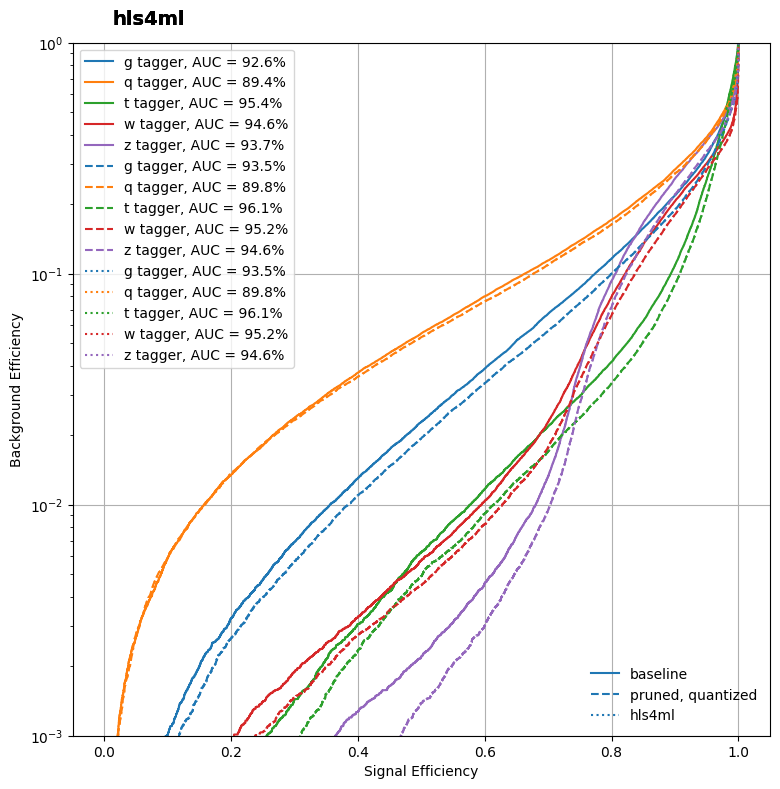

In [13]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test, batch_size=1024, verbose=0)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_keras_softmax, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls_softmax, classes, linestyle=':')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_3.1/hls4ml_prj/vitis_hls.log`

In [ ]:
hls_model.build(csim=False)

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Utilization Estimates' section in particular this time.

## Notice
We strip away the softmax layer compare to part 4, which takes 3~5 cycles to compute. The overall latency could be comparable.

In [ ]:
hls4ml.report.read_vivado_report('model_3.1/hls4ml_prj')

Print the report for the model trained in part 4. You should notice that the resource usage is significantly lower than the model trained in part 4.

**Note you need to have trained and synthesized the model from part 4**

In [ ]:
hls4ml.report.read_vivado_report('model_3/hls4ml_prj')

## NB
Note as well that the Vitis HLS `csynth` resource estimates tend to _overestimate_ on chip resource usage. Running the subsequent stages of FPGA compilation reveals the more realistic resource usage, You can run the next step, 'logic synthesis' with `hls_model.build(synth=True, vsynth=True)`, but we skipped it in this tutorial in the interest of time.